In [139]:
import random
import os
import numpy as np
import gc
import matplotlib.pyplot as plt
import dask.array as da
import cv2

from tqdm import tqdm
from constants import *
from utils import *

print('Preloading all data...')

dataDir = 'npy-color-augmented-elastic'
x_data = []
y_data = []

data_indices = list(range(1, 3))
for i in tqdm(data_indices):
    x_path = os.path.abspath(os.path.join(dataDir, 'x_data_' + str(i) + '.npy'))
    y_path = os.path.abspath(os.path.join(dataDir, 'y_data_' + str(i) + '.npy'))
    
    x_train = np.load(x_path, mmap_mode='r')
    y_train = np.load(y_path, mmap_mode='r')
    y_processed = []
#     for j in range(y_train.shape[0]):
#         if np.amax(y_train[j]) == 0:
#             y_processed.append([0, 0, 0])
#         else:
#             cx, cy = get_coordinates(y_train[j])
#             y_processed.append([1, cx / WIDTH, cy / HEIGHT])

#     x_data.append(x_train)
#     y_data.append(np.array(y_processed))
    x_data.append(x_train)
    y_data.append(y_train)
    del x_train, y_train
    gc.collect()
print('Loaded!')

x_data = da.concatenate(x_data, axis=0)
y_data = da.concatenate(y_data, axis=0)

Preloading all data...


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

Loaded!


In [140]:
fid = 290
def plot(x, y):
    plt.imshow(x, vmin=0, vmax=255)
    plt.show()
    plt.imshow(y, cmap='gray')
    plt.show()

In [141]:
def slice_windows(X, Y):
    index = ( np.expand_dims(np.arange(NUM_CONSEC), 0) + 
              np.expand_dims(np.arange(len(X)-NUM_CONSEC), 0).T )
    return X[index], Y[index]

In [142]:
wx, wy = slice_windows(np.array(x_data[40:60]).astype('uint8'), np.array(y_data[40:60]))

In [127]:
import numpy as np
import os
import piexif

from glob import glob
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras import optimizers

from constants import *
from utils import *

import random
import shutil
import pandas as pd
import cv2


def genHeatMap(w, h, cx, cy, r):
    if cx < 0 or cy < 0:
        return np.zeros((h, w), dtype=np.float32)
    x, y = np.meshgrid(np.linspace(1, w, w), np.linspace(1, h, h))
    heatmap = ((y - (cy + 1))**2) + ((x - (cx + 1))**2)
    heatmap[heatmap <= r**2] = 1
    heatmap[heatmap > r**2] = 0
    return heatmap

def augment(image, params):
    image = augmenter.apply_transform(image, params)
    return image

augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

def create_data(image, params):
    W, H = image.shape[1], image.shape[0]
    print(W,H)
    # Factor of 2 to compensate for eventual rescaling
    mask = genHeatMap(W, H, params['xy'][0], params['xy'][1], 2*sigma)# if params['vis'] else np.zeros((H, W))
    mask = np.expand_dims(mask, axis=-1)
    
    print(params['xy'])
    plt.imshow(image.astype('uint8'), vmin=0, vmax=255)
    plt.show()
    plt.imshow(mask)
    print(np.max(mask))
    plt.show()
    
    # Generate a random augmentation
    if params['augment']:
        image = augment(image, params)
        mask = augment(mask, params)
    
    plt.imshow(image.astype('uint8'), vmin=0, vmax=255)
    plt.show()
    plt.imshow(mask)
    print(np.max(mask))
    plt.show()
    print(image)
    # Resize the images
    image = resize(image, (HEIGHT, WIDTH)) / 255
    mask = np.squeeze(resize(mask, (HEIGHT, WIDTH)))
    if grayscale:
        image = np.average(image, axis=-1)
        
    x = 1/0
    return image, mask

Processing frames...
Done loading frames...
1280 720
(519.0, 152.0)


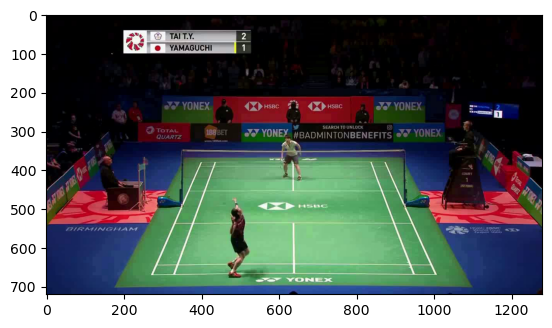

1.0


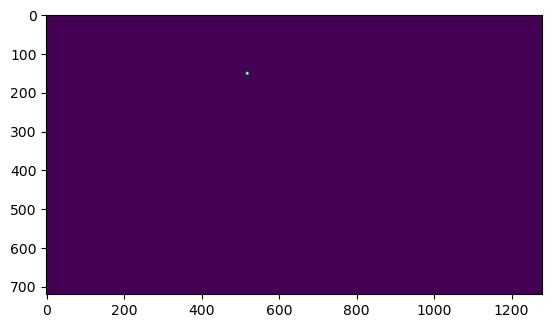

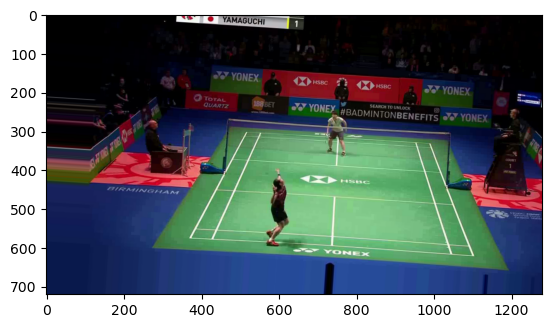

1.0


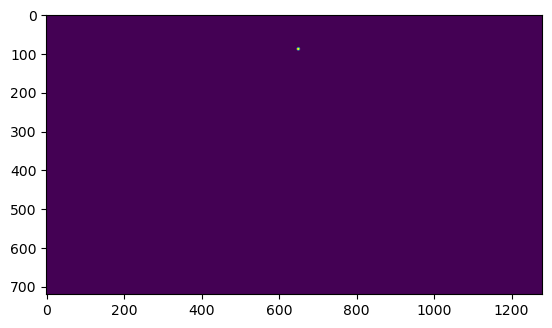

[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 4.  0.  0.]
  [ 4.  0.  0.]
  [ 4.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 4.  0.  0.]
  [ 4.  0.  0.]
  [ 4.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 4.  0.  0.]
  [ 4.  0.  0.]
  [ 4.  0.  0.]]

 ...

 [[ 9. 25. 76.]
  [ 9. 25. 76.]
  [ 9. 25. 76.]
  ...
  [14. 29. 84.]
  [14. 29. 84.]
  [14. 29. 84.]]

 [[ 9. 25. 76.]
  [ 9. 25. 76.]
  [ 9. 25. 76.]
  ...
  [14. 29. 84.]
  [14. 29. 84.]
  [14. 29. 84.]]

 [[ 9. 25. 76.]
  [ 9. 25. 76.]
  [ 9. 25. 76.]
  ...
  [14. 29. 84.]
  [14. 29. 84.]
  [14. 29. 84.]]]


ZeroDivisionError: division by zero

In [119]:
game_list = ['/home/code-base/scratch_space/data/match' + str(i) for i in range(1, 27)]

for game in game_list:
    train_path = glob(os.path.join(game, 'frame', '*'))
    
    for i in range(len(train_path)):
        train_path[i] = train_path[i][len(os.path.join(game, 'frame')) + 1:]
    for p in train_path:
        print('Processing frames...')
        labelPath = os.path.join(game, 'ball_trajectory', p + '_ball.csv')
        data = pd.read_csv(labelPath)
        no = data['Frame'].values
        v = data['Visibility'].values
        x = data['X'].values
        y = data['Y'].values
        r = os.path.join(game, 'frame', p)
        num = no.shape[0]
        images = [load_img(os.path.join(r, str(i) + '.jpg')) for i in no]
        ratiox, ratioy = images[0].size[0] / WIDTH, images[0].size[1] / HEIGHT
        print('Done loading frames...')

        for t in range(2):
            x_data_tmp = []
            y_data_tmp = []

            params = augmenter.get_random_transform((images[0].size[1], images[0].size[0]))
            params['augment'] = 1
            for i in range(num):
                params['vis'] = v[i]
                params['xy'] = (x[i], y[i])
                image = img_to_array(images[no[i]])
                a, b = create_data(image, params)

                x_data_tmp.append(a)
                y_data_tmp.append(b)

                del a, image
                del b

            x_data = np.asarray(x_data_tmp).astype('float16')
            y_data = np.asarray(y_data_tmp).astype('float16')

            np.save(os.path.join(dataDir, 'x_data_' + str(count) + '.npy'), x_data)
            np.save(os.path.join(dataDir, 'y_data_' + str(count) + '.npy'), y_data)

            print('============================')
            print(count)
            print(game, p)
            print(x_data.shape)
            print(y_data.shape)
            print('============================')

            del x_data_tmp
            del y_data_tmp
            del x_data
            del y_data
        del images

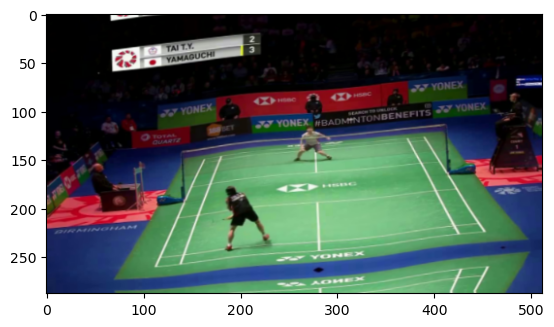

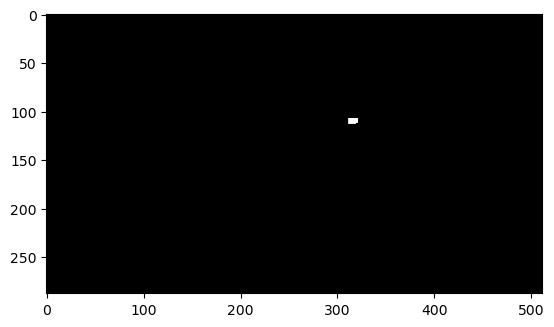

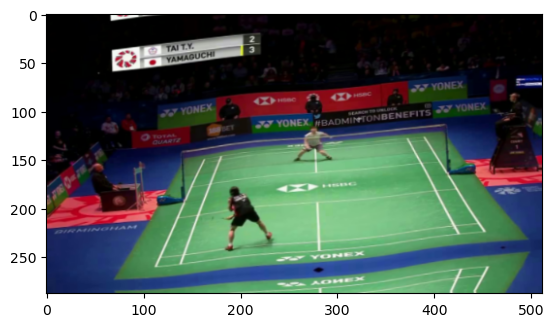

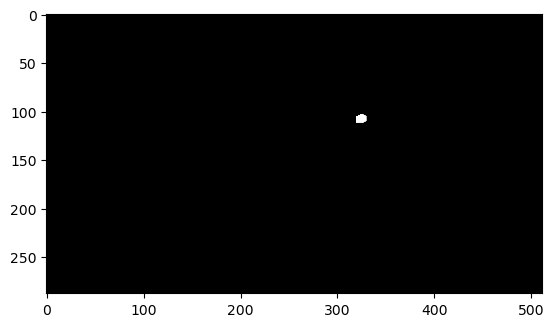

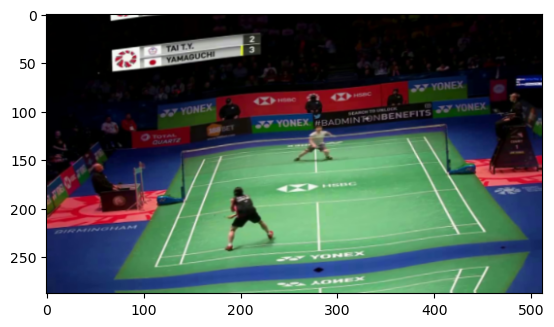

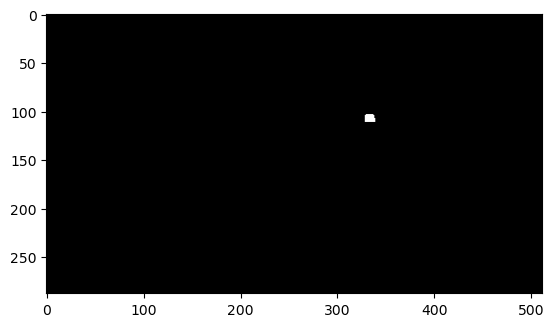

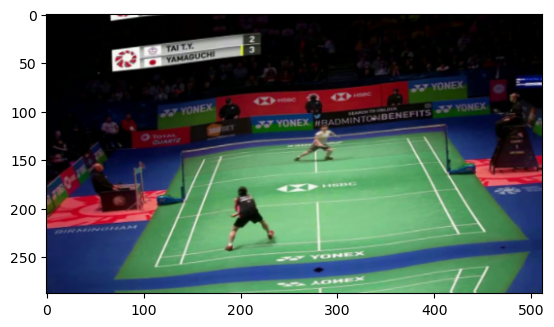

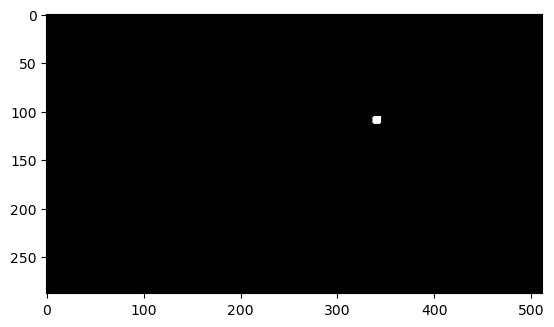

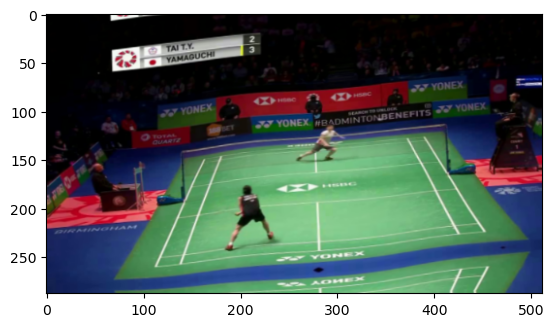

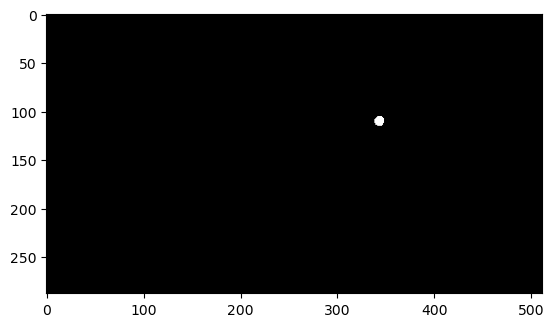

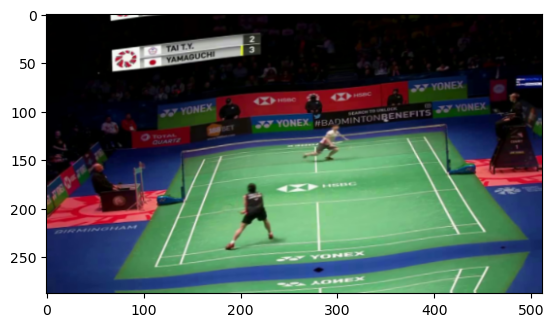

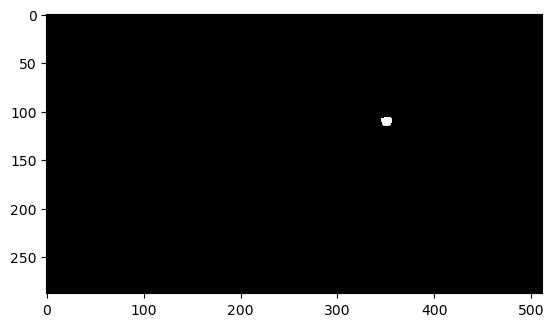

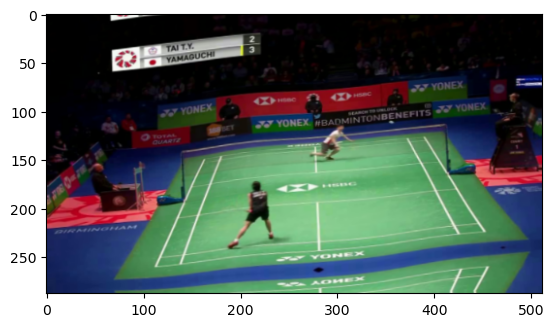

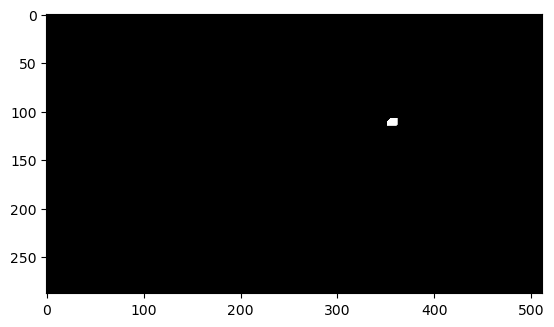

In [145]:
for i in range(435,442):
    X = x_data[i].compute().astype('uint8')
    Y = y_data[i].compute().astype('float32')
    image = X
    label = np.stack((Y,)*3, -1)
    #np.stack((X,)*3, -1)
#     cx, cy = y_data[i].compute()
#     image = cv2.circle(image, (int(cx * WIDTH), int(cy * HEIGHT)), 5, (0, 0, 255), -1)
    plot(image, label)

In [47]:
X

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]